In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from scipy.optimize import minimize


In [3]:
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import RealAmplitudes, QAOAAnsatz
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler, QiskitRuntimeService, EstimatorV2 as Estimator

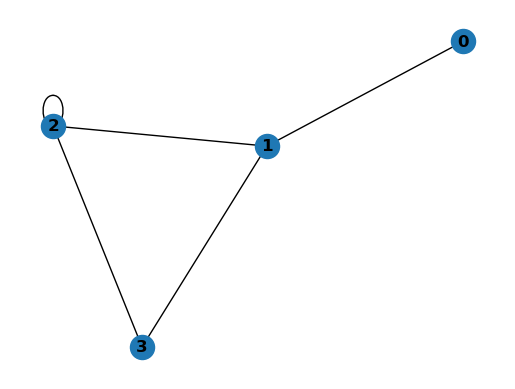

In [4]:
g = nx.Graph()
g.add_nodes_from([
    (0, {"weight": 1, "start": "start"}),
    (1, {"weight": 1}),
    (2, {"weight": 1}),
    (3, {"weight": 1, "start": "end"}),
])
g.add_edges_from([
    (0, 1),
    (1, 2),
    (1, 3),
    (2, 2),
    (2, 3),
])
subax1 = plt.plot()
nx.draw_kamada_kawai(g, with_labels=True, font_weight='bold')

In [5]:
def normalise_node_weights(graph: nx.Graph, normalisation: float) -> nx.Graph:
    """Normalises weights of nodes in a graph by a constant factor.

    Args:
        graph (nx.Graph): a node-weighted graph, with node attribute "weight".
        normalisation (float): the constant factor to normalise weights by.

    Returns:
        nx.Graph: a graph with node attributes "normalised_weight".
    """
    for node in graph.nodes:
        graph.nodes[node]["normalised_weight"] = round(graph.nodes[node]["weight"] / normalisation)
    return graph

In [6]:
def graph_to_max_path_digraph(graph: nx.Graph) -> nx.DiGraph:
    """Converts a (normalised) node-weighted graph to a corresponding directed graph with extra nodes.
    
    Nodes with weight > 1 are split into multiple nodes.
    A new "end" node is added.
    Suitable edges are added so that a max path on the new graph corresponds to a max path on the original graph.

    Args:
        graph (nx.Graph): a node-weighted graph.

    Returns:
        nx.DiGraph: an unweighted, directed graph.
    """
    dg = nx.DiGraph()
    for node in graph.nodes:
        weight = graph.nodes[node]["normalised_weight"]
        for k in range(weight):
            dg.add_node(f'{node}_{k}')
        
    for edge in graph.edges:
        if not edge[0] == edge[1]:
            weight_i = graph.nodes[edge[0]]["normalised_weight"]
            weight_j = graph.nodes[edge[1]]["normalised_weight"]
            for i in range(weight_i):
                for j in range(weight_j):
                    dg.add_edges_from([
                        (f'{edge[0]}_{i}', f'{edge[1]}_{j}'),
                        (f'{edge[1]}_{j}', f'{edge[0]}_{i}')
                    ])
        else:
            weight = graph.nodes[edge[0]]["normalised_weight"]
            for i in range(weight - 1):
                dg.add_edge(
                    f'{edge[0]}_{i}', f'{edge[0]}_{i + 1}'
                )
        
    dg.add_node('end_0')
    for node in graph.nodes:
        try:
            if graph.nodes[node]["start"] == "end":
                weight = graph.nodes[node]["normalised_weight"]
                for i in range(weight):
                    dg.add_edge(f'{node}_{i}', 'end_0')
                    dg.nodes[f'{node}_{i}']["start"] = "end"
            elif graph.nodes[node]["start"] == "start":
                dg.nodes[f'{node}_{0}']["start"] = "start"
        except:
            pass
    
    dg.add_edge('end_0', 'end_0')        
    
    return dg

In [7]:
def get_max_path_problem_qubo_matrix(graph: nx.DiGraph, penalty: int) -> np.ndarray:
    """Generates a matrix describing the max path problem qubo cost function.
    The cost function is C(x) = x^T Q x, where Q is the matrix returned by this function.

    Args:
        graph (nx.DiGraph): the directed graph describing the max path problem.
        penalty (int): the penalty for breaking constraints.

    Returns:
        np.ndarray: a 2D array Q representing the cost function.
    """
    nodes = list(graph.nodes)
    end_node = nodes[-1]
    W = len(nodes) - 1
    
    qubo_matrix = np.zeros(shape=(W+1, W+1, W+1, W+1), dtype=int)
    # Reward travelling along real edges
    for t in range(W):
        for i, j in product(range(W+1), range(W+1)):
            if (nodes[i], nodes[j]) not in graph.edges:
                qubo_matrix[t, i, t+1, j] += penalty
            else:
                qubo_matrix[t, i, t+1, j] += -1 if (nodes[i] != end_node and nodes[j] != end_node) else 0
    
    # Penalise not being in exactly 1 location at each time
    for t in range(W+1):
        for i in range(W+1):
            qubo_matrix[t, i, t, i] -= penalty
            for j in range(i+1, W+1):
                qubo_matrix[t, i, t, j] += 2 * penalty
           
    # Penalise multiple visits to a real node     
    for i in range(W):
        for t1 in range(W+1):
            for t2 in range(t1+1, W+1):
                qubo_matrix[t1, i, t2, i] += penalty
    
    # Reward starting at the start
    for i in range(W):
        try:
            if graph.nodes[nodes[i]]["start"] == "start":
                qubo_matrix[0, i, 0, i] -= penalty
        except:
            pass
        
    # Reward ending at the end
    qubo_matrix[W, W, W, W] -= penalty
    
    qubo_matrix = qubo_matrix.reshape(((W+1)**2, (W+1)**2))
    qubo_matrix = 0.5 * (qubo_matrix + qubo_matrix.T)
    
    return qubo_matrix


In [8]:
g = normalise_node_weights(g, 1)
dg = graph_to_max_path_digraph(g)
W = len(dg.nodes) - 1
penalty = W
qubo_matrix = get_max_path_problem_qubo_matrix(dg, penalty)

In [9]:
def build_hamiltonian(qubo_matrix: np.ndarray):
    pauli_list = []
    for i in range(qubo_matrix.shape[0]):
        for j in range(i, qubo_matrix.shape[1]):
            if not qubo_matrix[i, j] == 0:
                pauli_op = ["I"] * qubo_matrix.shape[0]
                pauli_op[i], pauli_op[j] = "Z", "Z"
                pauli_list.append(("".join(pauli_op), qubo_matrix[i, j] * (2 if not i == j else 1)))
    
    b = - sum(qubo_matrix[:, j] + qubo_matrix[j, :].T for j in range(qubo_matrix.shape[0]))
    for i in range(b.shape[0]):
        if not b[i] == 0:
            pauli_op = ["I"] * qubo_matrix.shape[0]
            pauli_op[i] = "Z"
            pauli_list.append(("".join(pauli_op), b[i]))
    
    hamiltonian = SparsePauliOp.from_list(pauli_list)
    
    return hamiltonian

In [10]:
H = build_hamiltonian(qubo_matrix)

In [11]:
circuit = QAOAAnsatz(cost_operator=H, reps=2, flatten=True)
circuit.measure_all()

In [12]:
service = QiskitRuntimeService(channel='ibm_quantum')
aer_sim = AerSimulator()

# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3,
                                    backend=aer_sim)

candidate_circuit = pm.run(circuit)
# candidate_circuit.draw('mpl', fold=False, idle_wires=False)

In [13]:
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta, initial_gamma, initial_beta]

In [14]:
objective_func_vals = [] # Global variable

def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)

    return cost


with Session(backend=aer_sim) as session:
    estimator = Estimator(mode=session)

    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit, H, estimator),
        method="COBYLA",
        tol=1e-3,
    )
    print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -7.9814453125
       x: [ 3.265e+00  3.053e+00  3.086e+00  1.502e+00]
    nfev: 55
   maxcv: 0.0


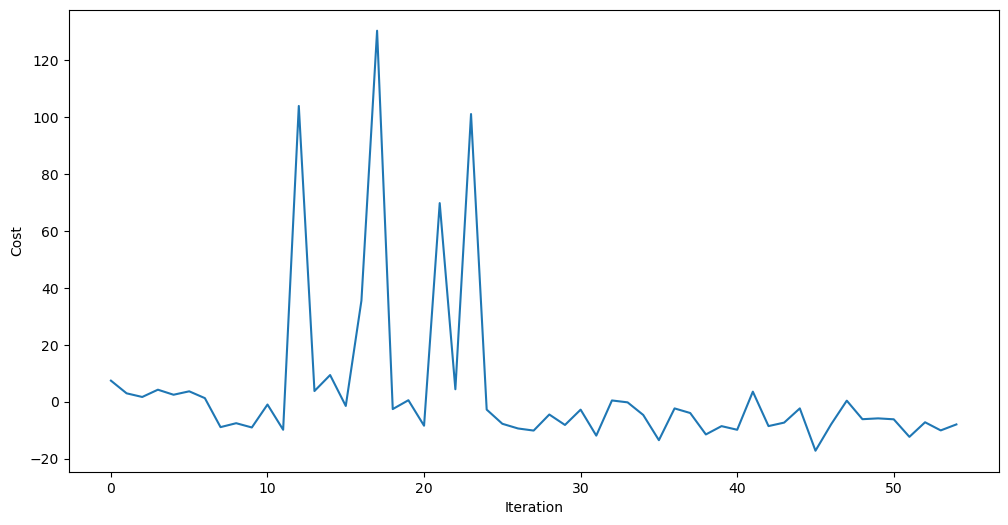

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

In [16]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw('mpl', fold=False, idle_wires=False)

In [17]:
sampler = Sampler(mode=aer_sim)
# sampler.options.default_shots = 100000

# Set simple error suppression/mitigation options
# sampler.options.dynamical_decoupling.enable = True
# sampler.options.dynamical_decoupling.sequence_type = "XY4"
# sampler.options.twirling.enable_gates = True
# sampler.options.twirling.num_randomizations = "auto"

pub= (optimized_circuit, )
job = sampler.run([pub], shots=10 * (2 ** 15))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}

In [24]:
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, qubo_matrix.shape[0])
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [74]:
final_distribution_int[most_likely]

3e-05

In [23]:
l = {k for k, val in counts_bin.items() if val > 3}
l

{'0000000000001110000001000'}

In [26]:
most_likely_bitstring @ qubo_matrix @ most_likely_bitstring

8.0

In [30]:
sol = np.zeros(25)
sol[0] = 1
sol[6] = 1
sol[12] = 1
sol[18] = 1
sol[24] = 1
sol @ qubo_matrix @ sol

-31.0

In [36]:
sol_str= [str(int(x)) for x in sol]
sol_str.reverse()
counts_bin["".join(sol_str)]

KeyError: '1000001000001000001000001'